# Downscaling global GDP by 3 sectors

In [12]:
import json
import glob
import io
import os
import re
import itertools as iter
import numpy as np

# data
import pandas as pd
import shapely as shp
import geopandas as gpd
import matplotlib as matplt
import matplotlib.pyplot as plt
import polars as pl
import geoarrow

# import shapely
import duckdb
import overturemaps
import h3
import scalenav
import scalenav.data as snd
import scalenav.scale_nav as sn
from scalenav.plotting import cmap
import scalenav.oop as snoo
import jinja2
from ipywidgets import HTML
from cartopy import crs as ccrs

# from scipy import io as io
# import nctoolkit as nc
# import xarray as xr
# import rioxarray as rx

from pyarrow import float16

import ibis as ib
from ibis import _
import ibis.selectors as s

ib.options.interactive = True
ib.options.graphviz_repr = True

# plots
from wordcloud import WordCloud

import pypalettes as pypal
import pydeck as pdk
from seaborn import color_palette

## Palettes and parameters

In [2]:
from parameters import *

## loading data 

In [3]:
conn = snoo.sn_connect()

In [4]:
dose_wdi = conn.read_parquet("../datasets/local_data/dose-wdi/0_3/dose_wdi_geo.parquet")

In [5]:
dose_wdi_df = dose_wdi.execute()

In [6]:
dose_wdi_df.set_geometry("geometry",inplace=True)
dose_wdi_df.set_crs(epsg=4326,inplace=True)
dose_wdi_df.head()

,gid_0,country,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015,centr,geometry,color,radius,x,y
0,ALB,Albania,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07,POINT (20.09077 40.6285),"POLYGON ((20.3794 40.43518, 20.37653 40.4361, ...","[238, 97, 0, 255]",19.888996,20.090775,40.628500
1,ALB,Albania,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07,POINT (20.24953 41.58911),"POLYGON ((20.42208 41.2819, 20.4225 41.28206, ...","[238, 97, 0, 255]",19.734250,20.249534,41.589105
2,ALB,Albania,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08,POINT (19.63037 41.44733),"POLYGON ((19.63813 41.34107, 19.6356 41.33656,...","[238, 97, 0, 255]",20.830796,19.630373,41.447333
3,ALB,Albania,ALB.4_1,7.954835e+08,3.681851e+08,1.731265e+08,1.573483e+08,POINT (20.18645 41.04003),"POLYGON ((20.43677 40.84906, 20.43671 40.8485,...","[238, 97, 0, 255]",20.494461,20.186454,41.040028
4,ALB,Albania,ALB.5_1,1.345159e+09,6.225993e+08,2.927561e+08,2.660753e+08,POINT (19.62053 40.77463),"POLYGON ((19.74395 40.45158, 19.74499 40.45683...","[238, 97, 0, 255]",21.019778,19.620528,40.774633


In [17]:
dose_wdi_df.head()

,gid_0,country,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015,centr,geometry,color,radius,x,y
0,ALB,Albania,ALB.1_1,4.341915e+08,2.009631e+08,9.449606e+07,8.588401e+07,POINT (20.09077 40.6285),"POLYGON ((20.3794 40.43518, 20.37653 40.4361, ...","[238, 97, 0, 255]",19.888996,20.090775,40.628500
1,ALB,Albania,ALB.2_1,3.719427e+08,1.721516e+08,8.094841e+07,7.357106e+07,POINT (20.24953 41.58911),"POLYGON ((20.42208 41.2819, 20.4225 41.28206, ...","[238, 97, 0, 255]",19.734250,20.249534,41.589105
2,ALB,Albania,ALB.3_1,1.113524e+09,5.153885e+08,2.423439e+08,2.202575e+08,POINT (19.63037 41.44733),"POLYGON ((19.63813 41.34107, 19.6356 41.33656,...","[238, 97, 0, 255]",20.830796,19.630373,41.447333
3,ALB,Albania,ALB.4_1,7.954835e+08,3.681851e+08,1.731265e+08,1.573483e+08,POINT (20.18645 41.04003),"POLYGON ((20.43677 40.84906, 20.43671 40.8485,...","[238, 97, 0, 255]",20.494461,20.186454,41.040028
4,ALB,Albania,ALB.5_1,1.345159e+09,6.225993e+08,2.927561e+08,2.660753e+08,POINT (19.62053 40.77463),"POLYGON ((19.74395 40.45158, 19.74499 40.45683...","[238, 97, 0, 255]",21.019778,19.620528,40.774633


## Proxy layers

In [18]:
# pois = conn.read_parquet("../datasets/overture/processed/places_landuses.parquet",table_name="pois")

In [19]:
# pois.head()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ id                               ┃ sec_cat   ┃ x          ┃ y          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ string                           │ string    │ float32    │ float32    │
├──────────────────────────────────┼───────────┼────────────┼────────────┤
│ 08bb25241a963fff0002b613c0af4307 │ education │ -68.591103 │ -31.536835 │
│ 08bb25241e65bfff0002b1fd4675b3dd │ park      │ -68.597771 │ -31.536121 │
│ 08bb25241e648fff0002bf710420a97e │ park      │ -68.596649 │ -31.535500 │
│ 08bb25241e646fff0002b1498b2457ba │ park      │ -68.597969 │ -31.534485 │
│ 08bb25241e645fff0002bd7a0e42ef1b │ park      │ -68.596848 │ -31.534323 │
└──────────────────────────────────┴───────────┴────────────┴────────────┘

## Plotting

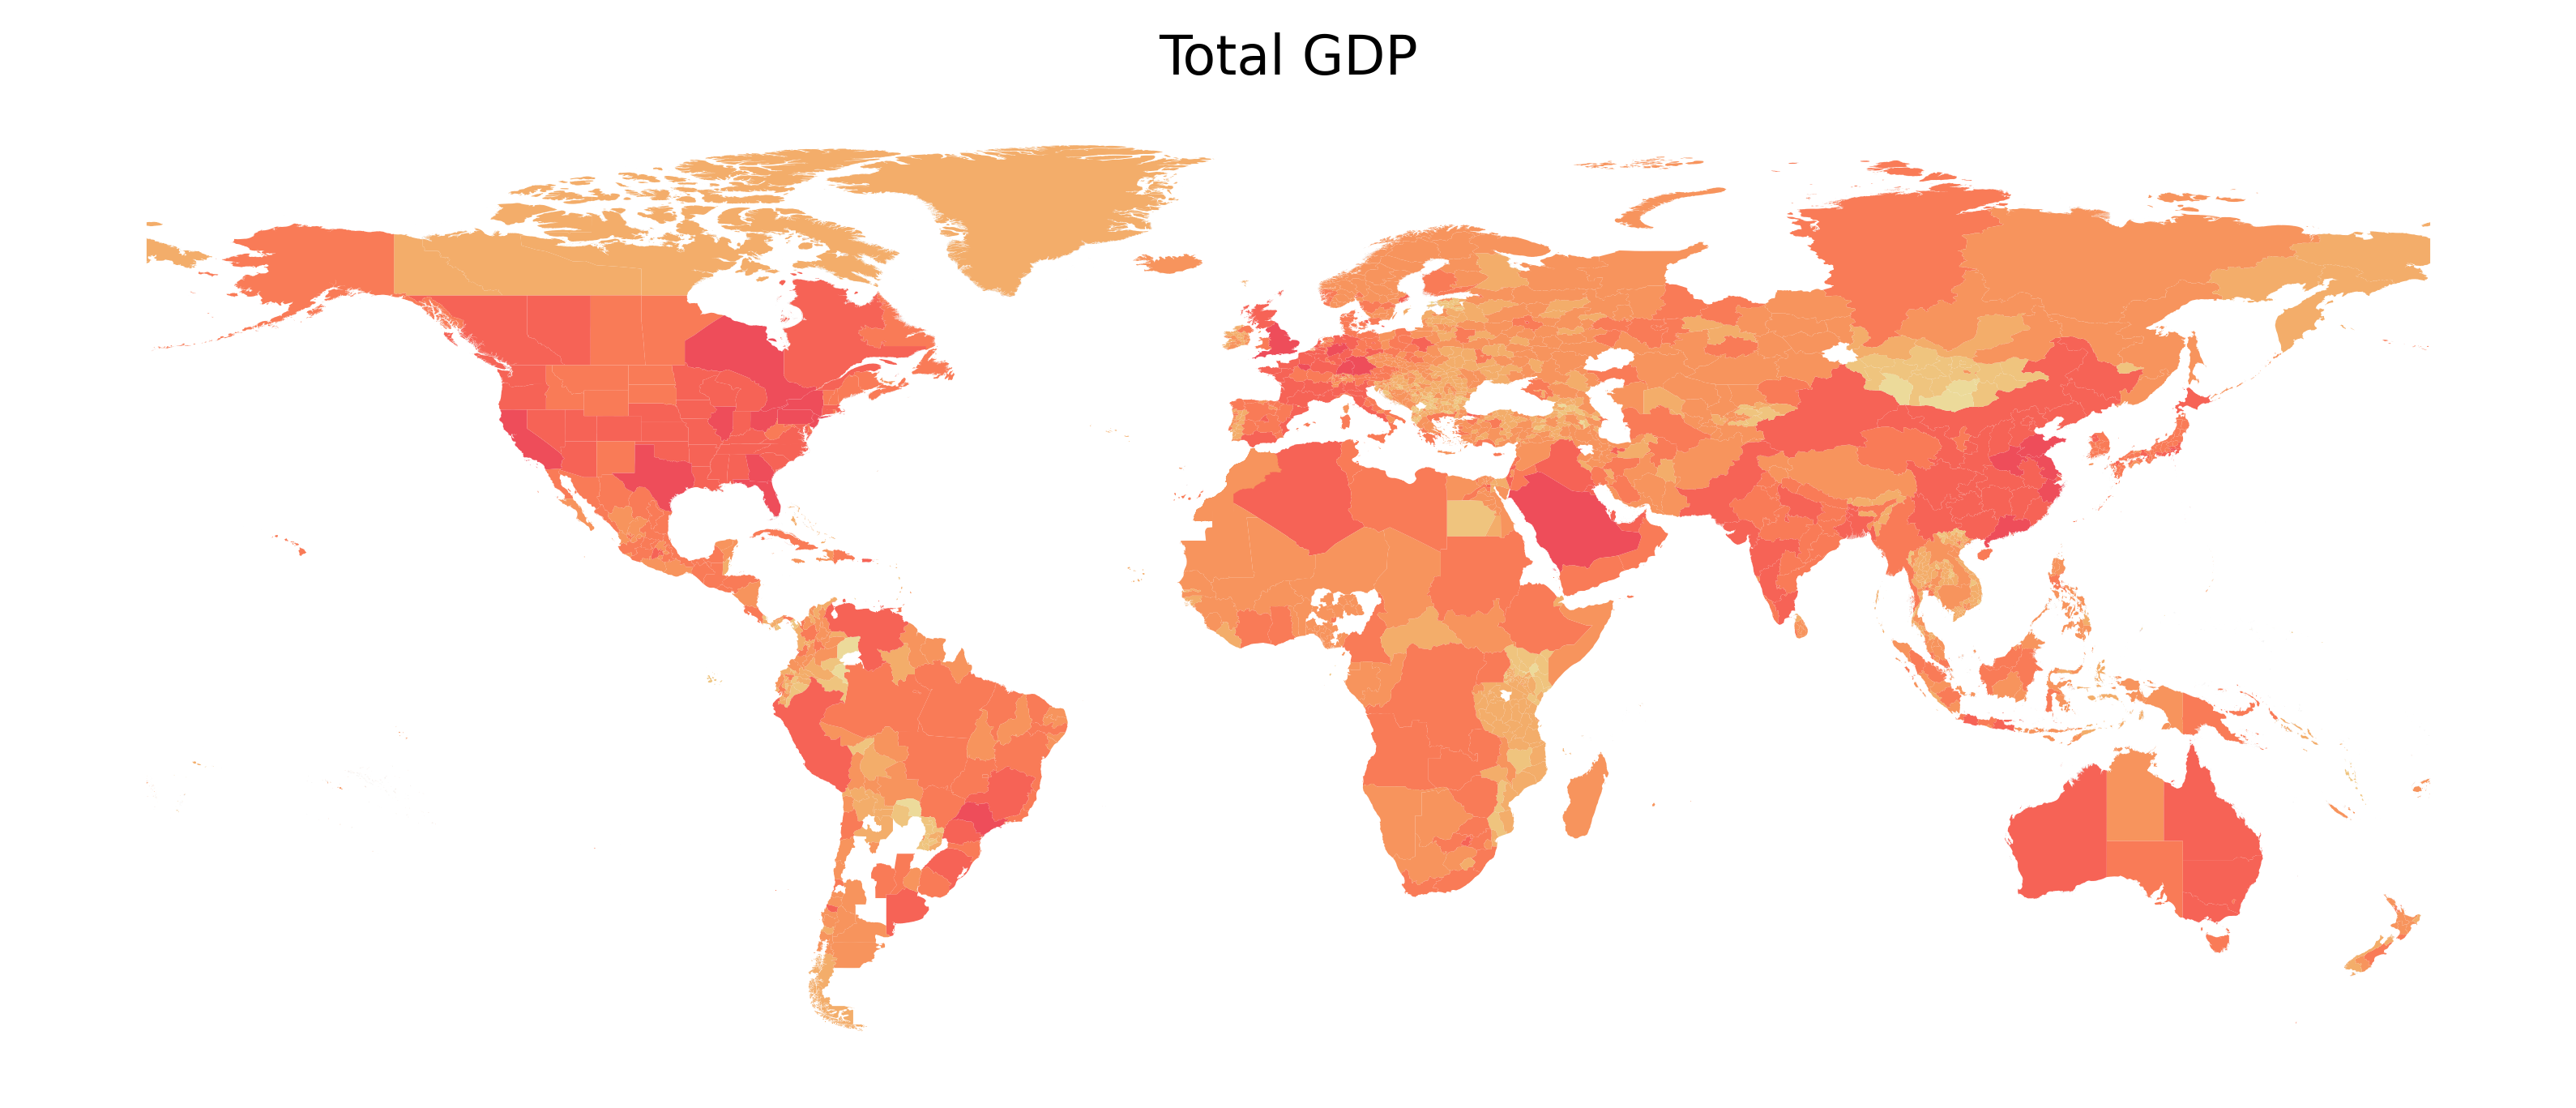

In [13]:
# Define the CartoPy CRS object.
crs = ccrs.PlateCarree()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
df_ae = dose_wdi_df.to_crs(crs_proj4)

# plotting normalisation
norm = matplt.colors.LogNorm(vmin=df_ae.grp_usd_2015.min(), vmax=df_ae.grp_usd_2015.max())

fig,ax = plt.subplots(figsize=(10,15),dpi=400)
df_ae.plot(ax=ax,column="grp_usd_2015",cmap = count_pal, norm = norm)
ax.set_axis_off()

plt.title("Total GDP")
plt.show()

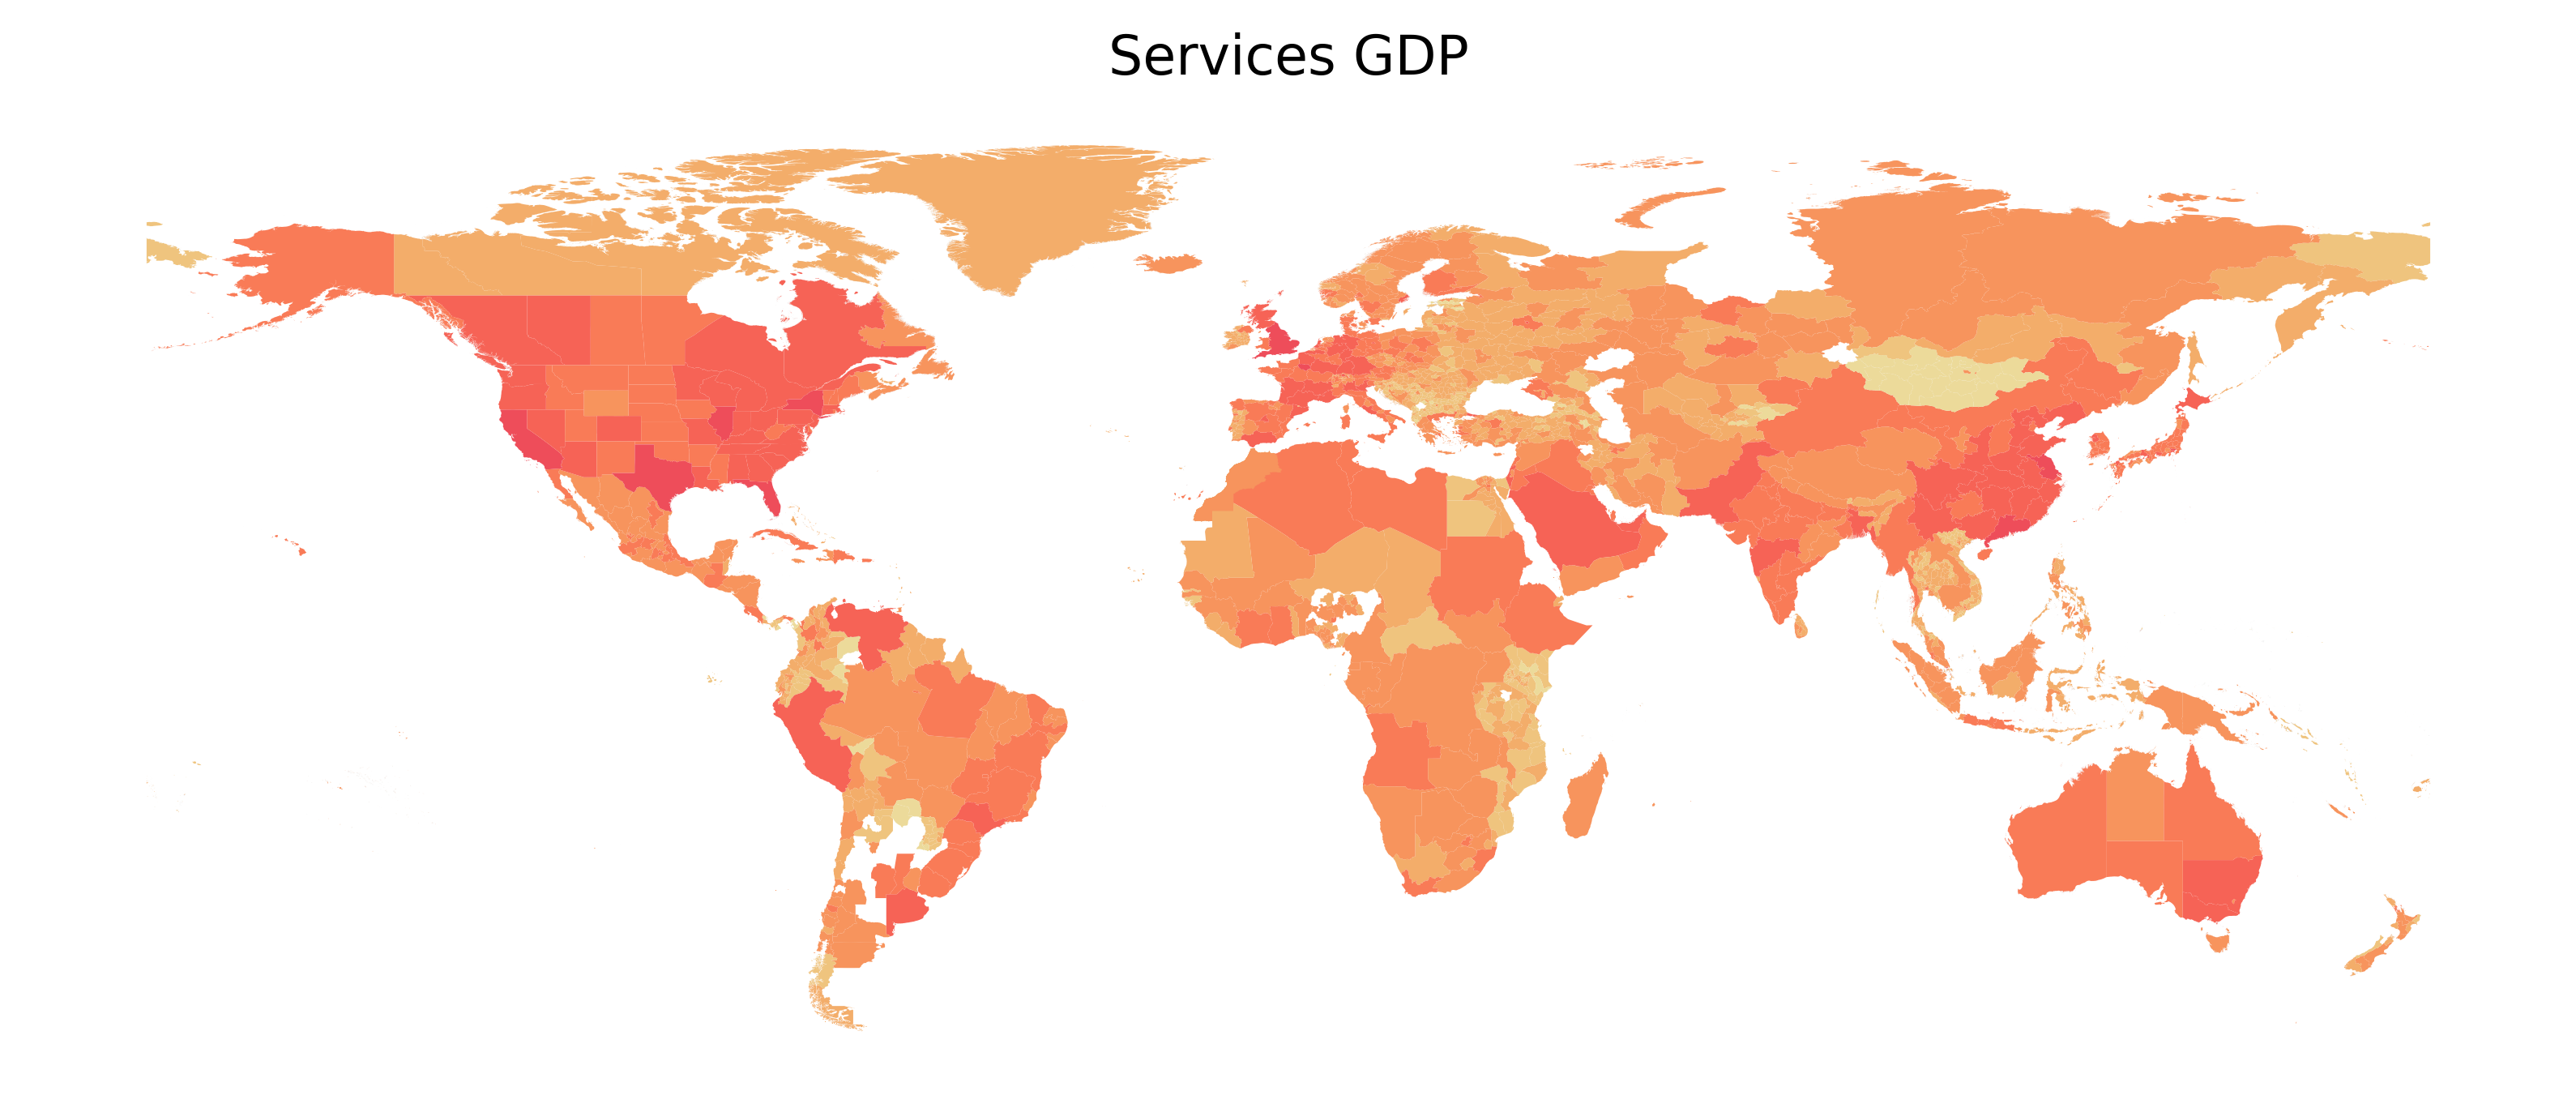

In [14]:
# Define the CartoPy CRS object.
crs = ccrs.PlateCarree()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
df_ae = dose_wdi_df.to_crs(crs_proj4)

fig,ax = plt.subplots(figsize=(10,15),dpi=400)
df_ae.plot(ax=ax,column="services_usd_2015",cmap = count_pal, norm = norm)
ax.set_axis_off()

plt.title("Services GDP")
plt.show()

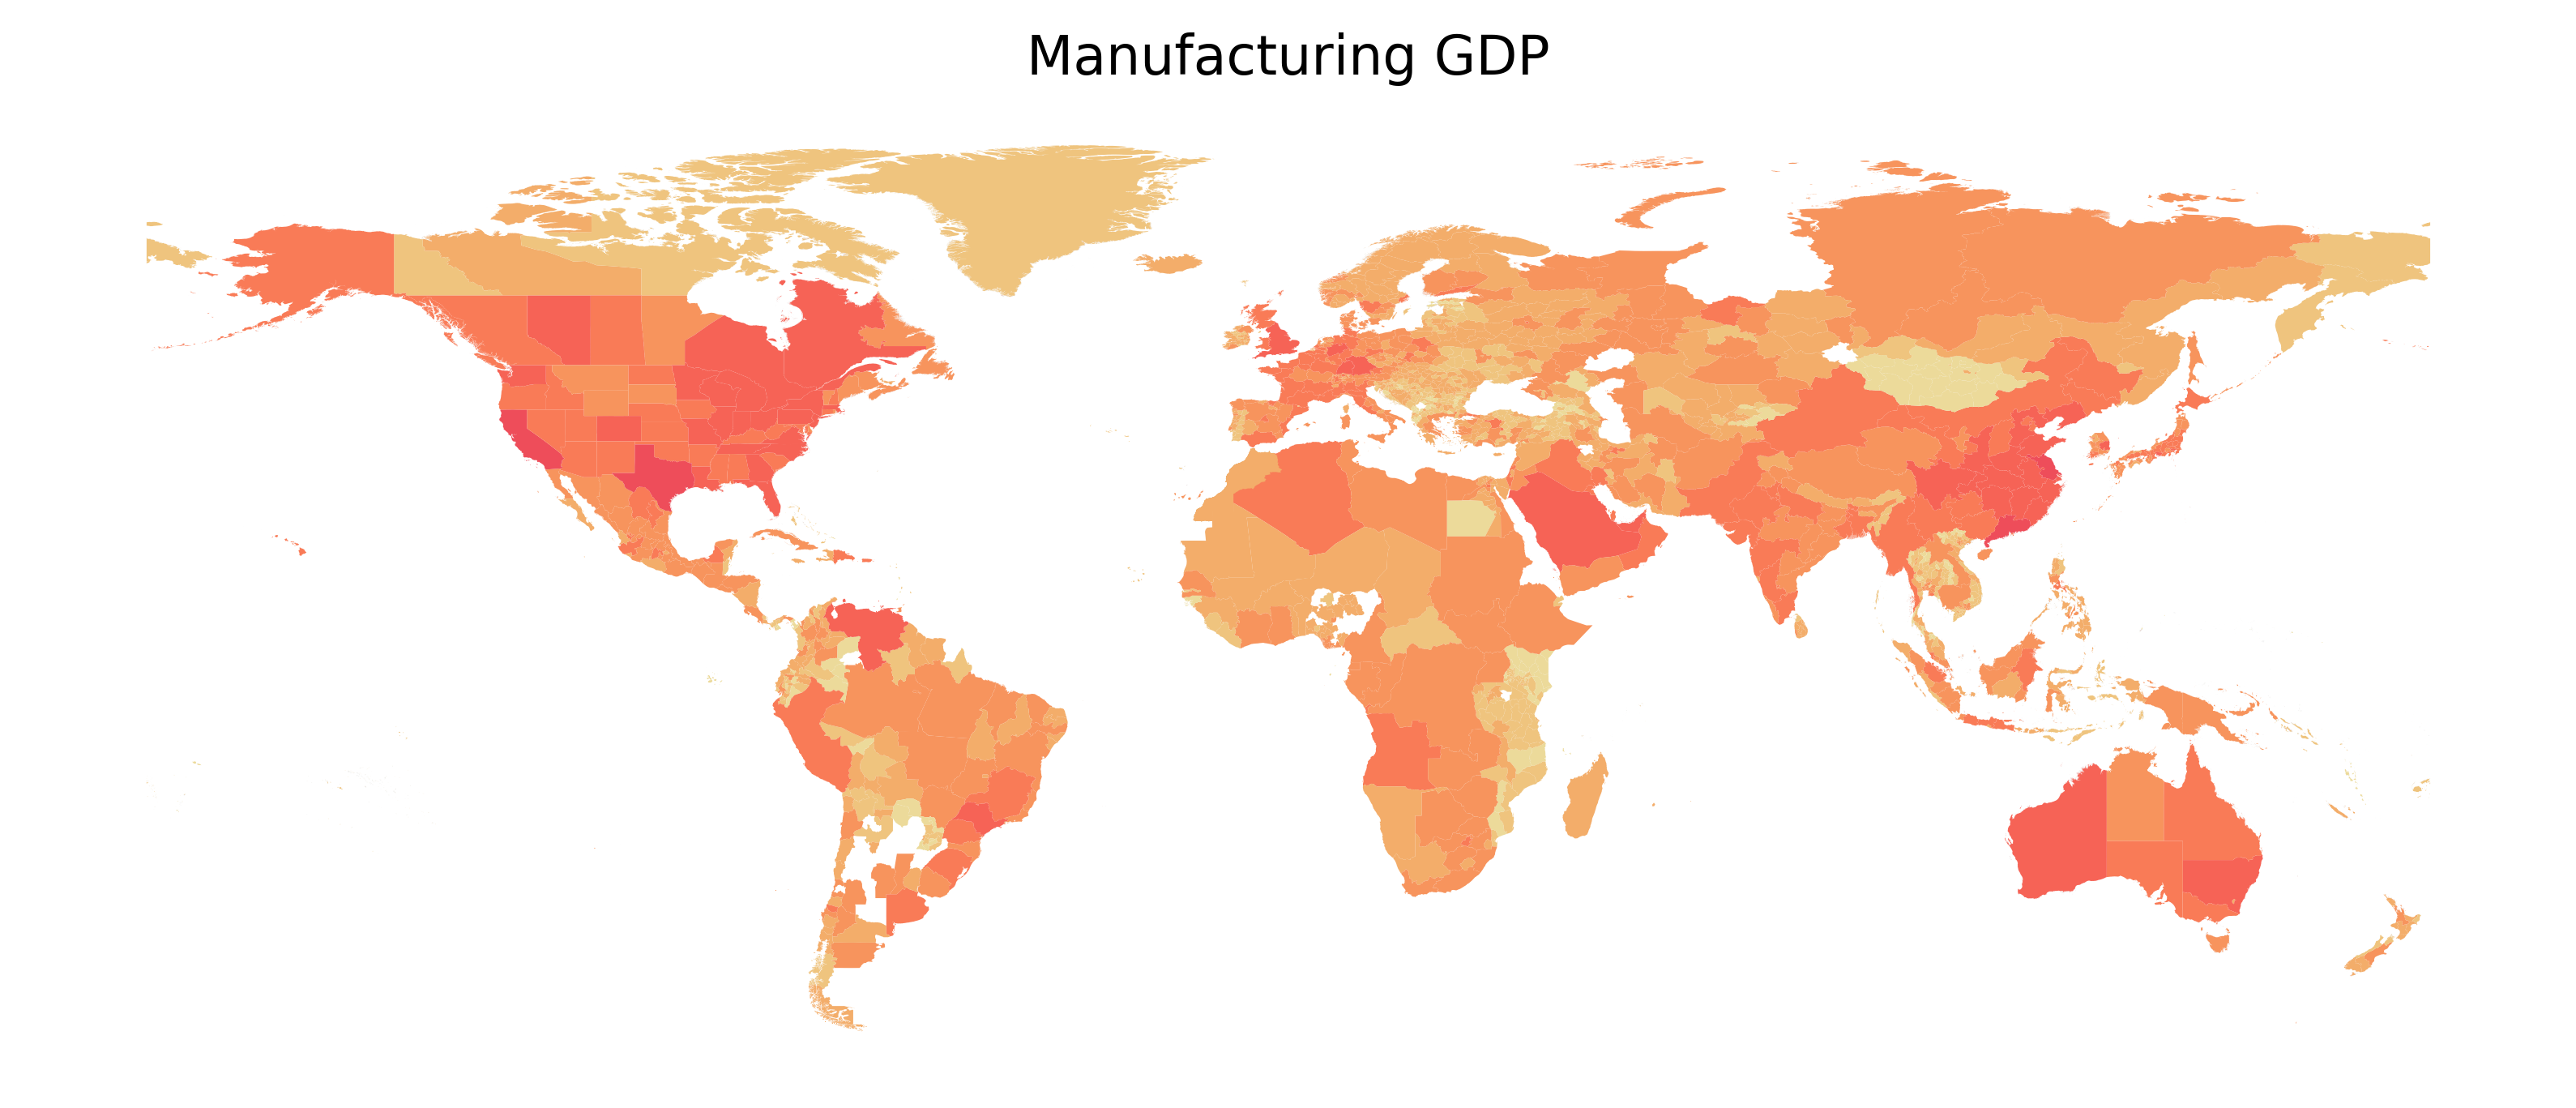

In [10]:
# Define the CartoPy CRS object.
crs = ccrs.PlateCarree()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
df_ae = dose_wdi_df.to_crs(crs_proj4)

fig,ax = plt.subplots(figsize=(10,15),dpi=400)
df_ae.plot(ax=ax,column="manufacturing_usd_2015",cmap = count_pal, norm = norm)
ax.set_axis_off()

plt.title("Manufacturing GDP")
plt.show()

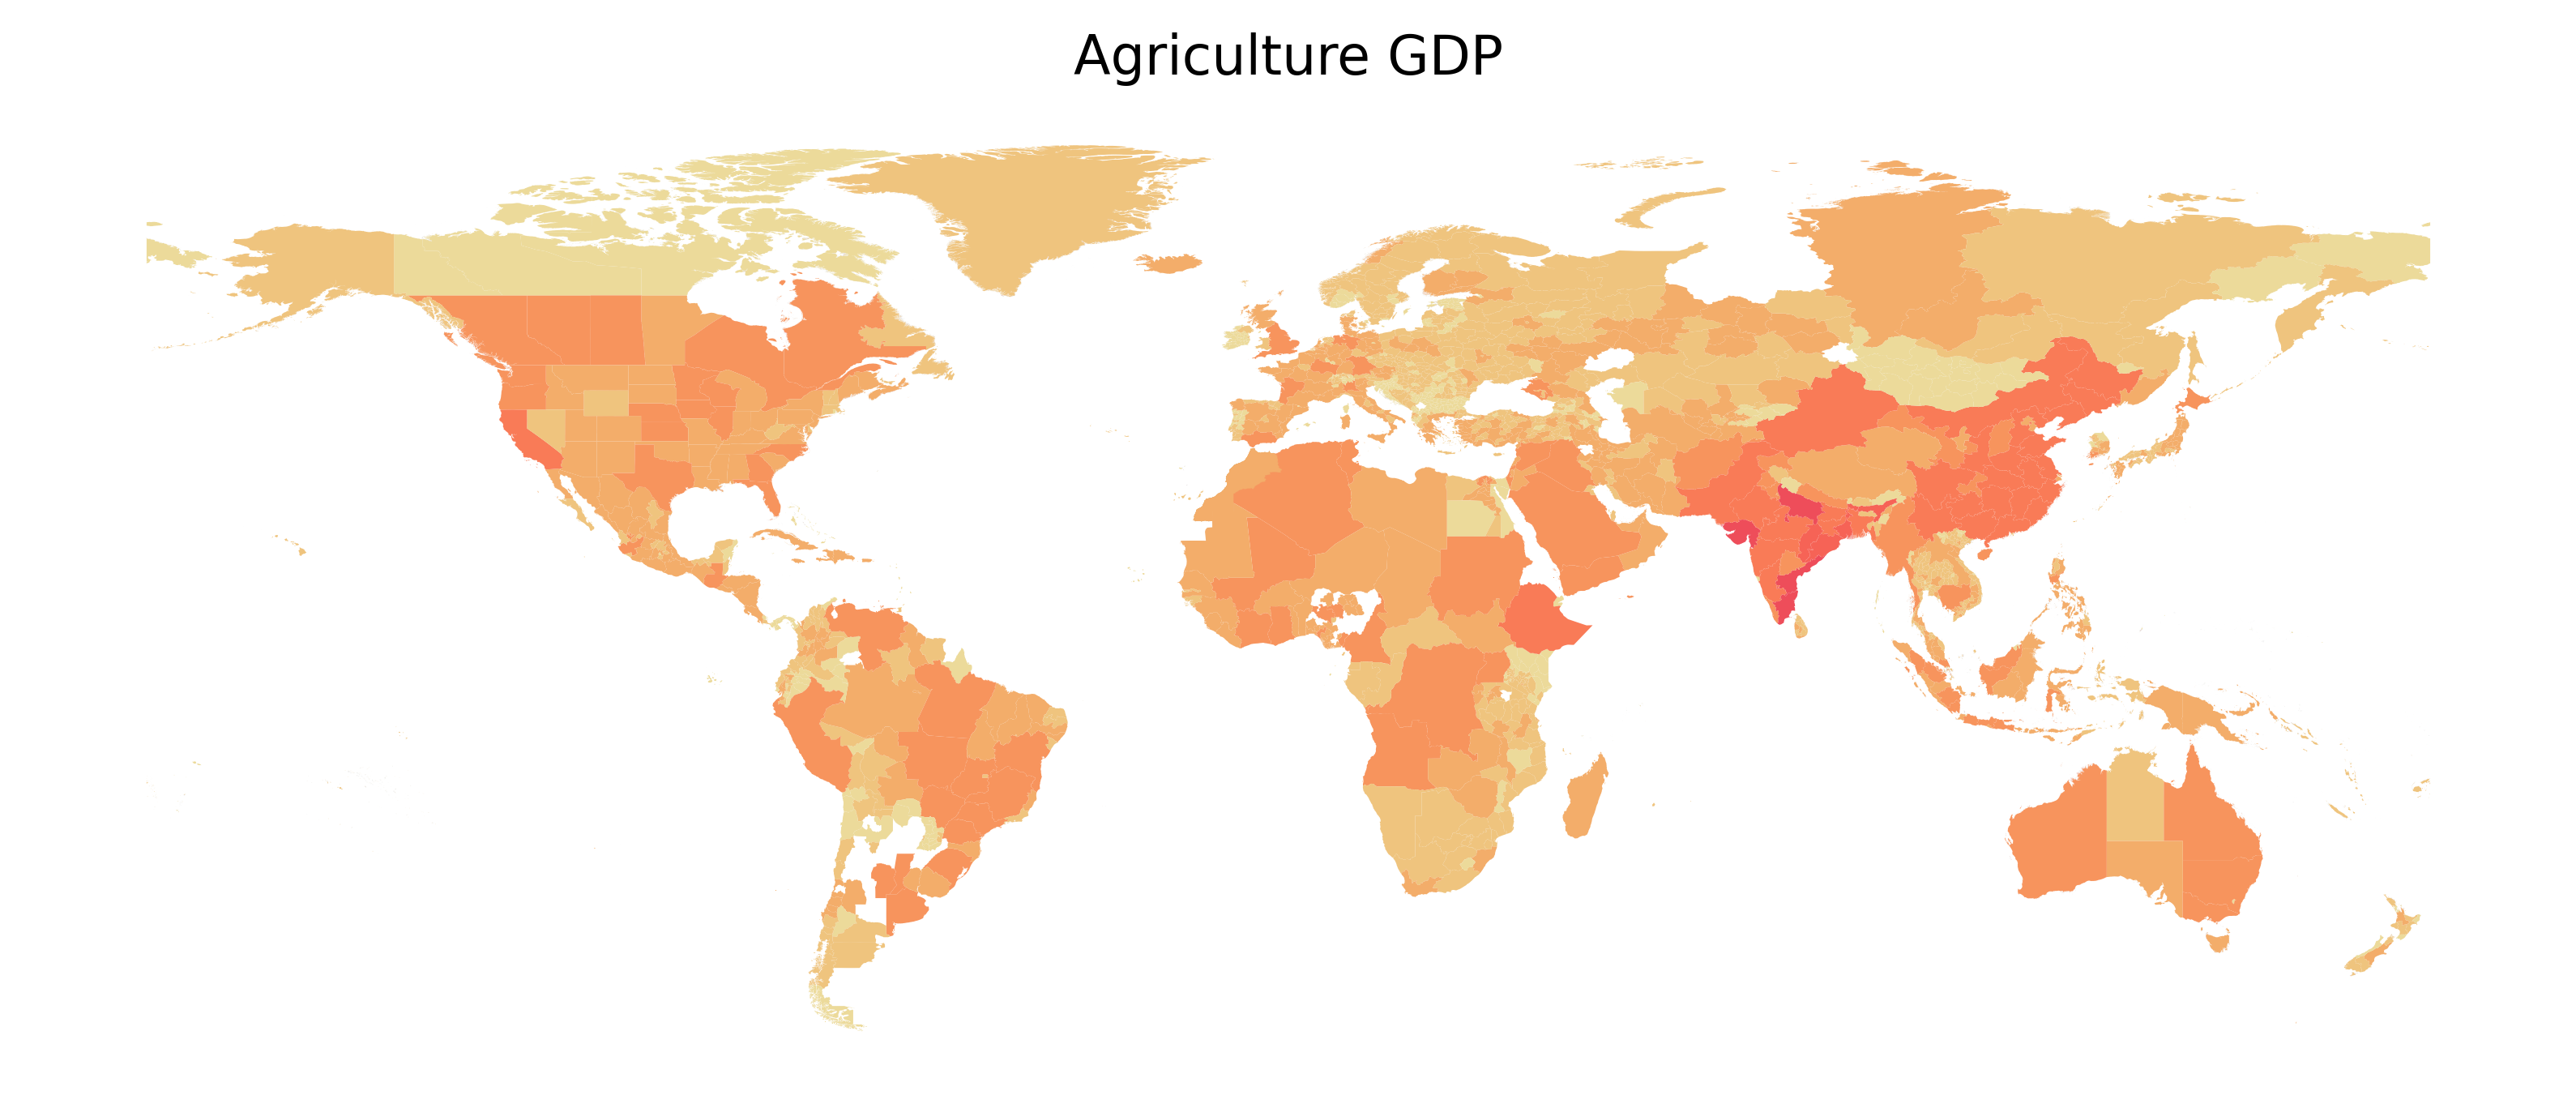

In [16]:
# Define the CartoPy CRS object.
crs = ccrs.PlateCarree()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
df_ae = dose_wdi_df.to_crs(crs_proj4)

fig,ax = plt.subplots(figsize=(10,15),dpi=400)
df_ae.plot(ax=ax,column="agriculture_usd_2015",cmap = count_pal, norm = norm)
ax.set_axis_off()
plt.title("Agriculture GDP")
plt.show()

## Downscale

In [23]:
pois_h3 = snoo.sn_project(pois,res=7)

Assuming coordinates columns ('x','y')


In [25]:
pois_h3.count()

┌──────────┐
│ 72162880 │
└──────────┘